In [433]:
import os
import numpy as np
import pandas as pd
import glob
import glob2
from matplotlib import pylab as plt
import cv2
from skimage.filters import threshold_otsu, gaussian
from skimage.filters.rank import median
from skimage.morphology import disk
import logging
from tqdm import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')


In [434]:
import os
import random
import numpy as np
import struct
from PIL import Image
from PIL import ImageFilter
import pickle
import glob2
from matplotlib import pylab as plt

In [435]:
def maybe_make_new_dir(dir_path):
    import pathlib
    pathlib.Path(dir_path).mkdir(parents=True, exist_ok=True) 

In [436]:
basedir = '/Users/megatron/DL/'
test_dir = os.path.join(basedir, 'test')
train_dir = os.path.join(basedir, 'train')
train_files = glob.glob(os.path.join(train_dir, '*', '*'))
test_files = glob.glob(os.path.join(test_dir, '*'))
key_fn = lambda x: x.split(os.sep)[-2]

# generate train_dict
train_dict = {}
for x in train_files:
    key = key_fn(x)
    if key not in train_dict:
        train_dict[key] = []
    train_dict[key].append(x)

In [437]:
len(train_dict.keys())

100

In [8]:
def resize(image_array, target_max=224):
    logging.info('image size before {}'.format(image_array.shape))
    shape = image_array.shape
    max_side = max(shape)
    ratio = target_max / max_side
    logging.info('resize ratio', ratio)
    if ratio > 1:
        interpolation = cv2.INTER_LINEAR
    else:
        interpolation = cv2.INTER_AREA        
    resize_array = cv2.resize(image_array, (0, 0), fx=ratio, fy=ratio, interpolation=interpolation)
    logging.info('image size after {}'.format(resize_array.shape))
    return resize_array


def pad_to_square(image_array, bg_white=True):
    shape = image_array.shape
    assert len(shape) == 2
    max_side = max(shape)
    median_margin = np.median(list(image_array[:5, :].flatten()) + list(image_array[-5:, :].flatten()) + 
                            list(image_array[:, :5].flatten()) + list(image_array[:, -5:].flatten()))
    logging.info('median_margin', median_margin)
    if median_margin < 1:
        canvas = np.zeros((max_side, max_side))
    else:
        canvas = np.ones((max_side, max_side))
    pad_size = (max_side - np.array(shape)) // 2
    canvas[pad_size[0]:(pad_size[0] + shape[0]), pad_size[1]:(pad_size[1] + shape[1])] = image_array
    if bg_white and median_margin < 1:
        canvas = 1 - canvas
    return canvas


def normalize(image_array):
    return image_array.astype(float) / 255

In [285]:
train_dict['和']
filepath = '/Users/megatron/DL/train/和/5d6bea89e620dc997cd27c8ed97b347d9dd1948c.jpg'
filepath = '/Users/megatron/DL/train/和/5ced83803a34147e164f7e408b32f37783c8bf40.jpg'
filepath = '/Users/megatron/DL/train/和/4cb35c1fd4c9b2df39c31da1ffe1544d67c67d23.jpg'
# filepath = '/Users/megatron/DL/train/守/5eafb030130f3beab2f59f419d8e2f1afd209e60.jpg'

# filepath = train_dict['和'][3]

## workflow

1. Normalize to [0, 1]
2. Resize max side to 224
3. Apply Gaussian blur
4. Binarize with Otsu threshold
5. Pad to square (224, 224)

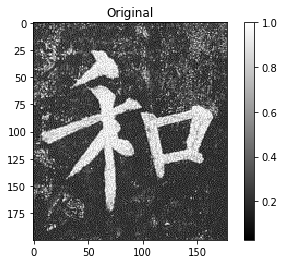

In [286]:
image_array = plt.imread(filepath, -1)
image_array = normalize(image_array) # to [0, 1]
plt.imshow(image_array)
plt.title('Original')
plt.colorbar()

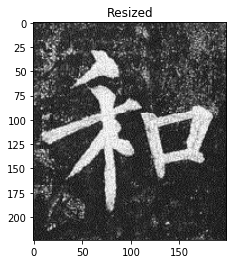

In [287]:
resize_array = resize(image_array, target_max=224)
plt.imshow(resize_array)
plt.title('Resized')

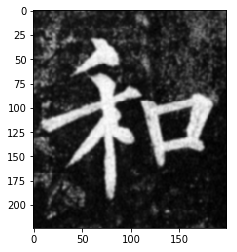

In [288]:
blurred_array = gaussian(resize_array, 1)
plt.imshow(blurred_array)

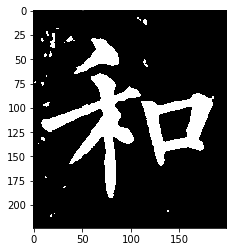

In [289]:
th = threshold_otsu(blurred_array)
binary_array = (blurred_array > th).astype(np.uint8)
plt.imshow(binary_array)

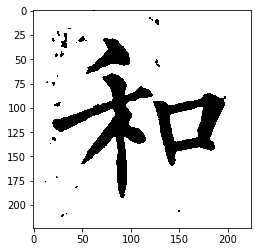

In [290]:
square_array = pad_to_square(binary_array, bg_white=True)
plt.imshow(square_array)

## TODO: Some odd cases

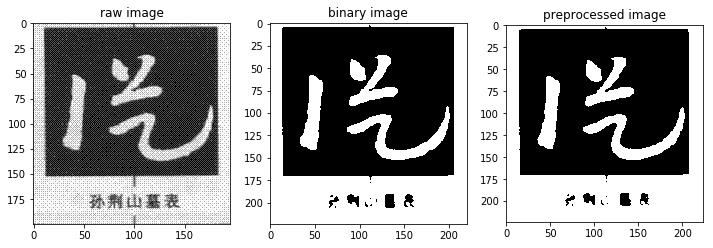

In [301]:
filepath = '/Users/megatron/DL/train/从/8a37d0a2ecd3ed6372f6cf45eea4c20e0405d118.jpg'
image_array, binary_array, square_array = preprocess_image(filepath)
show_preprocess(image_array, binary_array, square_array)

In [296]:
image_array.shape

(200, 196)

In [307]:
stats = cv2.connectedComponentsWithStats(binary_array)

In [308]:
stats

(7, array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32), array([[   13,     2,   193,   204, 27784],
        [    0,     0,   220,   224, 16967],
        [   88,    36,    55,    57,  1083],
        [   89,    40,    18,    25,   328],
        [   33,    58,    26,    83,  1242],
        [   86,    93,   115,    60,  1875],
        [  157,   196,     1,     1,     1]], dtype=int32), array([[109.5031313 ,  86.43341492],
        [109.9291566 , 155.37496316],
        [117.19113573,  68.81348107],
        [ 96.83231707,  53.05182927],
        [ 47.55555556, 101.39774557],
        [144.3504    , 127.43946667],
        [157.        , 196.        ]]))

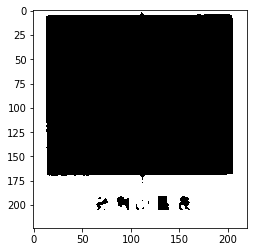

In [318]:
plt.imshow(stats[1] == 1)

In [300]:
def preprocess_image(filepath):
    """Return preprocessed image from filepath
    """
    image_array = plt.imread(filepath, -1)
    normal_array = normalize(image_array) # to [0, 1]
    resize_array = resize(normal_array, target_max=224)
    blurred_array = gaussian(resize_array, 1)
    th = threshold_otsu(blurred_array)
    binary_array = (blurred_array > th).astype(np.uint8)
    square_array = pad_to_square(binary_array, bg_white=True)
    preproc_array = (square_array * 255).astype(np.uint8)
    return image_array, binary_array, preproc_array


def show_preprocess(image_array, binary_array, square_array):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image_array)
    plt.title('raw image')
    plt.subplot(132)
    plt.imshow(binary_array)
    plt.title('binary image')
    plt.subplot(133)
    plt.imshow(square_array)
    plt.title('preprocessed image')

## Experiment with some other examples

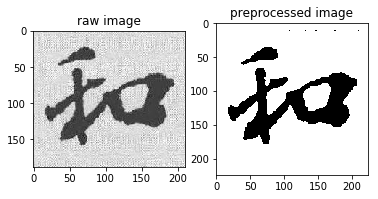

In [273]:
filepath = train_dict['和'][10]
image_array, square_array = preprocess_image(filepath)
show_preprocess(image_array, square_array)

In [274]:
train_dir

'/Users/megatron/DL/train'

In [275]:
new_train_dir = r'/Users/megatron/DL/train_preproc'

In [ ]:
## Batch process all training examples

In [324]:
keys = sorted(train_dict.keys())
for key in tqdm(keys[35:]):
#     print(key)
    files = train_dict[key]
    for file in (files):
#         print(file)
        try:
            new_file = file.replace(train_dir, new_train_dir)
            maybe_make_new_dir(os.path.dirname(new_file))
            _, _, preproc_array = preprocess_image(file)
            cv2.imwrite(new_file, preproc_array)
        except:
            print(file)

  0%|          | 0/65 [00:00<?, ?it/s]

/Users/megatron/DL/train/守/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


  2%|▏         | 1/65 [00:02<02:17,  2.14s/it]

/Users/megatron/DL/train/宗/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


 29%|██▉       | 19/65 [00:40<01:38,  2.14s/it]

/Users/megatron/DL/train/易/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


 74%|███████▍  | 48/65 [01:42<00:36,  2.14s/it]

/Users/megatron/DL/train/臣/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


 85%|████████▍ | 55/65 [02:02<00:22,  2.23s/it]

/Users/megatron/DL/train/足/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


 98%|█████████▊| 64/65 [02:33<00:02,  2.39s/it]

/Users/megatron/DL/train/鼎/6652e6ce434be5fcb49a987ab28246b7079a206f.jpg


100%|██████████| 65/65 [02:36<00:00,  2.41s/it]


In [447]:


class DataSet:
    def __init__(self, search_path, is_train=True, char_dict=None):
        self.file_counter = 0
        self.is_train = is_train
        self.iter_index = 0
        self.files = glob2.glob(search_path)
        self.char_dict = char_dict
        self.use_filter = False
        self.use_rotation = True
        self.get_char_dict()
    
    def get_char_dict(self):
        self.num_dict = dict(enumerate(sorted(set([self.gen_tagcode(file) for file in self.files]))))
        self.char_dict = {val:key for key, val in self.num_dict.items()}

    @staticmethod
    def gen_tagcode(file_name):
        return file_name.split(os.sep)[-2]
    
    @staticmethod
    def read_image(filepath):
        image_array = plt.imread(filepath, -1).astype(np.uint8)
        image_array = 255 - image_array
        return image_array

    def load_next_file(self):
        filepath = np.random.choice(self.files, replace=True)
        image_array = self.read_image(filepath)
        tag = self.gen_tagcode(filepath)
        num = self.char_dict[tag]
        if self.use_filter:
            image_array = self.apply_filter(image_array)
        if self.use_rotation:
            image_array = self.rotate(image_array)
        return image_array, num
    
    def load_all(self, files):
        x = []
        y = []
        for filepath in files:
            image_array = self.read_image(filepath)
            tag = self.gen_tagcode(filepath)
            num = self.char_dict[tag]
            if self.use_filter:
                image_array = self.apply_filter(image_array)
            if self.use_rotation:
                image_array = self.rotate(image_array)
            x.append(image_array)
            y.append(num)
        return np.array(x), np.array(y)
    
    def rotate(self, image):
        im = Image.fromarray(image)
        im = im.rotate(random.randint(-10, 10)) # rotate slightly and randomly
        im = im.resize([64, 64])
        new_image = np.asarray(im)
        return new_image

    def apply_filter(self,image):
        im = Image.fromarray(image)
        filters = [ImageFilter.BLUR, ImageFilter.CONTOUR, ImageFilter.EMBOSS]
        im = im.filter(random.choice(filters))
        im = im.resize([64, 64])
        new_image = np.asarray(im)
        print('after filtering shape', new_image.shape)
#         new_image = new_image.reshape(new_image.shape[0], new_image.shape[1], 1)
        return new_image

    def train_valid_split(self, train_ratio=0.7):
        n_files = len(self.files)
        train_set = np.random.choice(self.files, int(train_ratio * n_files))
        valid_set = list(set(self.files) - set(train_set))
        return train_set, valid_set


In [375]:
import time
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from data_loader import ChineseWrittenChars
import keras



def build_model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=(64, 64, 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(100))

    model.add(Activation('softmax'))
    return model


def training(X_train,y_train):
    model = build_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    model.fit(X_train, y_train, epochs=1) # the more epoch the better
#     model.save('model.h5')


def testing(X_test, y_test):
    # load model
    from keras.models import load_model
    model = load_model('model.h5')
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    loaded_model_score = model.evaluate(X_test, y_test)
    print('test accuracy: ',loaded_model_score[1]) # the 0-th element is loss, the 1st element is accuracy
    print(model.metrics)


def app(train_or_test):
    if train_or_test == 'train':
        start_time = time.time()
        X_train, y_train = train_data.load_all()
        X_train = np.expand_dims(X_train/255, axis=3)
        y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
        print('load training used time:', time.time() - start_time)
        print (X_train.shape)
        print (y_train.shape)
        training(X_train, y_train)

    if train_or_test == 'test':
        X_test, y_test = chars.test.load_all()
        y_test = lb.transform(y_test)
        X_test /= 255
        testing(X_test, y_test)





In [376]:
train_data = DataSet(r'/Users/megatron/DL/train_preproc/**/*jpg')
test_data = DataSet(r'/Users/megatron/DL/test/**/*jpg')
test_data.use_rotation = False
test_data.use_filter = False

num_classes = 100

17
右


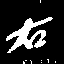

In [378]:
a, b = train_data.load_next_file()
print(b)
print(train_data.num_dict[b])
Image.fromarray(a)

In [380]:
X_train, y_train = train_data.load_all()

In [408]:
print(len(X_train), len(y_train))
print(X_train.shape, y_train.shape)

39994 39994
(39994, 64, 64) (39994,)


In [424]:
X_train_2 = np.expand_dims(X_train/255, axis=3)
y_train_2 = keras.utils.to_categorical(y_train, num_classes=num_classes)

In [426]:
print(X_train_2.shape, y_train_2.shape)

(39994, 64, 64, 1) (39994, 100)


In [427]:
training(X_train_2, y_train_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 128)       1280      
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 128)       512       
_________________________________________________________________
activation_7 (Activation)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 60, 60, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
__________

KeyboardInterrupt: 

(39994,)

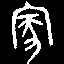

In [400]:
Image.fromarray(X_train[2000])

In [401]:
train_data.num_dict[y_train[2000]]

'家'